# Data 3

## importeren libraries

In [62]:
%pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter


Note: you may need to restart the kernel to use updated packages.


## Yfinance API

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-23)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


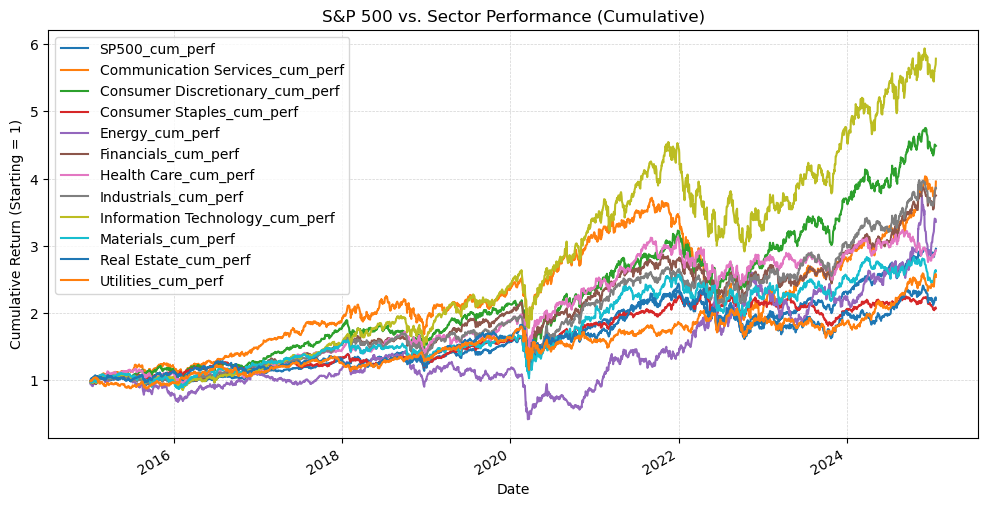

In [63]:

class SP500Analysis:
    def __init__(
        self,
        ticker='^GSPC',
        start_date='2014-01-01',
        end_date=None
    ):
        """
        Initialize the analysis object with default parameters.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')

        # Columns for cumulative sector performance
        self.sector_cols = [
            "Communication Services",
            "Consumer Discretionary",
            "Consumer Staples",
            "Energy",
            "Financials",
            "Health Care",
            "Industrials",
            "Information Technology",
            "Materials",
            "Real Estate",
            "Utilities"
        ]

        # Data placeholders
        self.sp500_df = None
        self.tickers_df = None
        self.all_tickers_close = None
        self.sector_df = None
        self.merged_df = None

    def calculate_rsi(self, series, period=14):
        """
        Calculate RSI (Relative Strength Index) for a given Series.
        """
        delta = series.diff(1)
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def add_bollinger_bands(self, df, window=20, num_std=2):
        """
        Calculate Bollinger Bands for a given DataFrame.
        """
        df['BB_MA'] = df['Close'].rolling(window).mean()
        df['BB_STD'] = df['Close'].rolling(window).std()
        df['BB_Upper'] = df['BB_MA'] + num_std * df['BB_STD']
        df['BB_Lower'] = df['BB_MA'] - num_std * df['BB_STD']
        return df

    def _flatten_columns(self, df):
        """
        If the DataFrame has a MultiIndex for columns, flatten them.
        """
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [
                '_'.join(str(level) for level in col if level)
                for col in df.columns
            ]
        return df

    def download_sp500_data(self):
        """
        Download S&P 500 (^GSPC) data and compute basic technical indicators.
        """
        # Download single-ticker data
        self.sp500_df = yf.download(
            self.ticker,
            start=self.start_date,
            end=self.end_date
        )

        self.sp500_df = self._flatten_columns(self.sp500_df)
        if 'Close' in self.sp500_df.columns:
            self.sp500_df.rename(columns={'Close': 'Close_^GSPC'}, inplace=True)

        # Calculate 50-day and 200-day Moving Averages on the S&P 500 close
        self.sp500_df['50_MA'] = self.sp500_df['Close_^GSPC'].rolling(window=50).mean()
        self.sp500_df['200_MA'] = self.sp500_df['Close_^GSPC'].rolling(window=200).mean()

        # Calculate RSI
        self.sp500_df['RSI'] = self.calculate_rsi(self.sp500_df['Close_^GSPC'], period=14)

        # Calculate Volatility (High - Low)
        if 'High' in self.sp500_df.columns and 'Low' in self.sp500_df.columns:
            self.sp500_df['Volatility'] = self.sp500_df['High'] - self.sp500_df['Low']

        # Bollinger Bands
        self.sp500_df = self.add_bollinger_bands(
            self.sp500_df.rename(columns={'Close_^GSPC': 'Close'}),  # rename temporarily
            window=20,
            num_std=2
        ).rename(columns={'Close': 'Close_^GSPC'})  # rename back

        # Reset index to have 'Date' as a column for merging
        self.sp500_df.reset_index(inplace=True)


    def download_sector_data(self):
        """
        - Scrape the list of S&P 500 companies from Wikipedia
        - Download their Close prices
        - Compute daily average close per sector
        - Compute daily change % for each sector
        - Pivot to wide format
        """
        # Scrape the S&P 500 tickers
        self.tickers_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
        self.tickers_df = self.tickers_df[['Symbol', 'GICS Sector', 'GICS Sub-Industry']]
        self.tickers_df.columns = ['Symbol', 'Sector', 'Industry']
        self.tickers_df.set_index('Symbol', inplace=True)

        # Get list of symbols
        symbols = self.tickers_df.index.to_list()

        # Download close prices for all S&P 500 symbols
        # This returns a DataFrame with columns=[tickers], index=[dates]
        self.all_tickers_close = yf.download(
            symbols,
            start=self.start_date,
            end=self.end_date,
            auto_adjust=True
        )['Close']

        # Flatten columns in case of any multi-level
        self.all_tickers_close = self._flatten_columns(self.all_tickers_close)

        # Reshape data: (Date, Symbol, Close)
        df_500 = self.all_tickers_close.stack().reset_index()
        df_500.columns = ['Date', 'Symbol', 'Close']

        # Merge with sector info
        df_500 = df_500.merge(
            self.tickers_df,
            how='left',
            left_on='Symbol',
            right_index=True
        )

        # Group by (Date, Sector) to get average close
        self.sector_df = (
            df_500
            .groupby(['Date', 'Sector'])['Close']
            .mean()
            .reset_index()
        )

        # Compute daily % change for each sector
        self.sector_df['Daily_Change'] = (
            self.sector_df
            .groupby('Sector')['Close']
            .pct_change()
        )

    def merge_sp500_with_sectors(self):
        """
        Merge the sector daily changes (pivoted) with the S&P 500 dataframe.
        Then compute daily & cumulative returns for the S&P 500 and each sector.
        """
        # Pivot sector_df to get daily change per sector as columns
        pivot_change = self.sector_df.pivot(
            index='Date',
            columns='Sector',
            values='Daily_Change'
        )
        pivot_change = self._flatten_columns(pivot_change)
        self.merged_df = self.sp500_df.copy()
        # self.merged_df has columns including 'Date' as a column

        # Merge pivot_change (index=Date) onto sp500_df (column=Date)
        self.merged_df = self.merged_df.merge(
            pivot_change,
            how='left',
            left_on='Date',
            right_index=True
        )

        self.merged_df['SP500_return'] = self.merged_df['Close_^GSPC'].pct_change()
        self.merged_df['SP500_cum_perf'] = (1 + self.merged_df['SP500_return']).cumprod()
        for sector in self.sector_cols:
            if sector in self.merged_df.columns:
                self.merged_df[f'{sector}_cum_perf'] = (1 + self.merged_df[sector]).cumprod()

        self.merged_df.set_index('Date', inplace=True)

    def plot_performance(self):
        """
        Plot the cumulative performance of the S&P 500 vs. the S&P sectors.
        """
        plot_cols = ['SP500_cum_perf']
        for col in self.sector_cols:
            col_name = f'{col}_cum_perf'
            if col_name in self.merged_df.columns:
                plot_cols.append(col_name)

        self.merged_df[plot_cols].plot(figsize=(12, 6))
        plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
        plt.title("S&P 500 vs. Sector Performance (Cumulative)")
        plt.ylabel("Cumulative Return (Starting = 1)")
        plt.show()

    def run(self):
        """
        Execute the entire workflow in the correct sequence.
        """
        self.download_sp500_data()
        self.download_sector_data()
        self.merge_sp500_with_sectors()
        self.plot_performance()


if __name__ == "__main__":
    analysis = SP500Analysis()
    analysis.run()



---

### 1. 50_MA (50-Day Moving Average)

#### What It Is
- A moving average is a line showing the average price over a number of days.
- It is a stock indicator commonly used in technical analysis.

#### Why It’s Important
- It helps providing a clearer view of the market’s underlying trend.
- The moving average helps to level the price data over a specified period by creating a constantly updated average price.
- A price above the 50-day MA can indicate an uptrend 
- A price below the 50-day MA can indicate a downtrend.

#### How It’s Calculated
1. Gather the closing prices for the last 50 trading days.
2. Sum those 50 closing prices.
3. Divide by 50 to get the average.

Mathematically:  
$$
50\_MA = \frac{1}{50} \sum_{i=1}^{50} \text{Close}_{t-i}
$$
Where $$\text{Close}_{t-i}$$ is the closing price $$i$$ days in the past.

---

### 2. 200_MA (200-Day Moving Average)

#### What It Is
- Similar to the 50-day MA, but over a longer period (200 days).

#### Why It’s Important
- It’s regarded as a measure of the long-term trend.
- To see the overall health of the market.  
- When a price is above the 200-day MA, it’s often considered a **bullish**  below it is considered **bearish**

#### How It’s Calculated
- Exactly like the 50-day MA, but using 200 days worth of closing prices.
- The formula:

$$
200\_MA = \frac{1}{200} \sum_{i=1}^{200} \text{Close}_{t-i}
$$

---

### 3. RSI (Relative Strength Index)

#### What It Is
- A popular indicattor that measures the speed** and change of price movements.

#### Why It’s Important
- RSI is used to identify overbought or oversold signs in the market.
   - a reading above **70** is overbought (price may have risen too far in a short time).
   - A reading below **30** is oversold (price may have fallen too far in a short time).


#### How It’s Calculated (14-Day RSI)
1. Calculate daily price changes.
2. Separate those changes into gains and losses .
3. Compute the average gain and average loss over a 14-day period.
4. Compute the relative strength (RS): |
$$
    RS = \frac{\text{Average Gain}}{\text{Average Loss}}
$$
1. Convert **RS** into an index (RSI) on a 0–100 scale: 
$$
    RSI = 100 - \left(\frac{100}{1 + RS}\right)
$$

---

### 4. BB_MA, BB_STD, BB_Upper, BB_Lower (Bollinger Bands)

Bollinger Bands are made up of:

1. **BB_MA (Middle Band)**  
2. **BB_STD (Standard Deviation)**  
3. **BB_Upper (Upper Band)**  
4. **BB_Lower (Lower Band)**  

#### What They Are
- A volatility indicator that consists of:
   - A moving average (often 20-day)  
   - Upper and Lower bands plotted at a certain number of standard deviations (often **2**) above and below that average.

#### Why They’re Important
- They expand and contract based on volatility:
   - When volatility is high, the bands widen.
   - When volatility is low, the bands narrow.
- Traders watch where the price sits relative to these bands:
   - Price hitting the upper band can suggest the asset may be **overbought** (or trending strongly upward).
   - Price hitting the lower band can suggest the asset may be **oversold** (or trending strongly downward).
- They help identify **potential breakouts** when the price moves outside the bands or the bands “squeeze” (narrow range) before a large move.

#### How They’re Calculated
Assume we use a 20-day Bollinger Band with 2 standard deviations:

1. **BB_MA**: 20-day simple moving average of Close.  
$$
    BB\_MA = \frac{1}{20}\sum_{i=1}^{20} \text{Close}_{t-i}
$$
1. **BB_STD**: 20-day standard deviation of Close:
$$
    BB\_STD = \sqrt{\frac{1}{19}\sum_{i=1}^{20} \left(\text{Close}_{t-i} - BB\_MA\right)^2 }
$$
    (Note: exact formula may vary based on sample vs. population standard deviation.)
1. **BB_Upper** = $$ BB\_MA + (2 \times BB\_STD) $$
2. **BB_Lower** = $$ BB\_MA - (2 \times BB\_STD) $$

(Where the multiplier, **2**, is the typical number of standard deviations.)

---



## 

## Database 

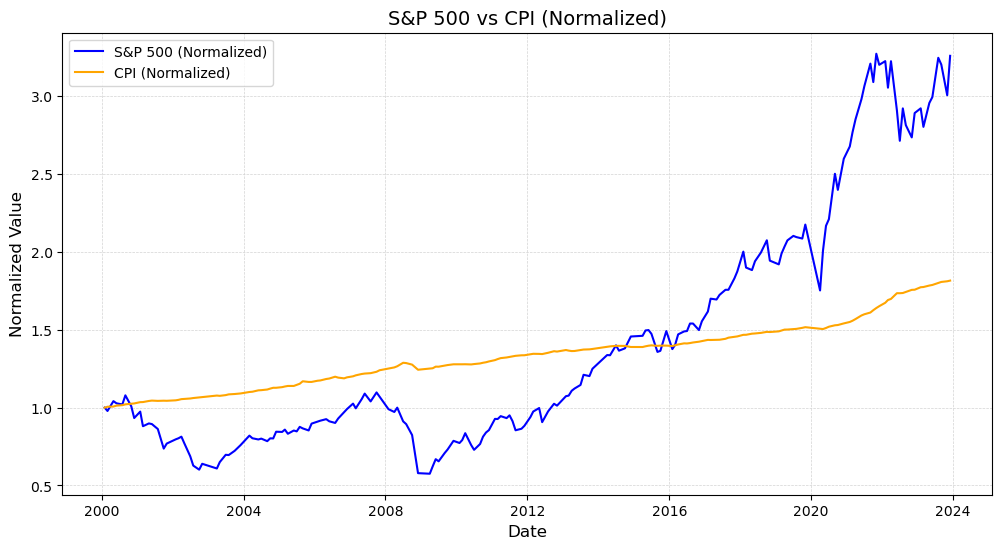

Correlation between S&P 500 returns and CPI changes: 0.2784


In [64]:

class SP500CPIAnalysis:
    def __init__(self, sp500_file='sp500_data.csv', cpi_file='cpi_data.csv'):
        """
        Initialize the analysis object with file paths for S&P 500 and CPI datasets.
        """
        self.sp500_file = sp500_file
        self.cpi_file = cpi_file

        self.sp500_data = None
        self.cpi_data = None
        self.merged_data = None

    def load_data(self):
        """
        Load and preprocess the S&P 500 and CPI datasets.
        """
        # Load data
        self.sp500_data = pd.read_csv(self.sp500_file)
        self.cpi_data = pd.read_csv(self.cpi_file)

        # Convert date columns to datetime format
        self.sp500_data['Date'] = pd.to_datetime(self.sp500_data['Date'])
        self.cpi_data['DATE'] = pd.to_datetime(self.cpi_data['DATE'])

        # Rename columns for consistency
        self.cpi_data.rename(columns={'DATE': 'Date', 'CPIAUCSL': 'CPI'}, inplace=True)

    def merge_data(self):
        """
        Merge S&P 500 and CPI datasets on the Date column.
        """
        self.merged_data = pd.merge(
            self.sp500_data,
            self.cpi_data,
            on='Date',
            how='inner'
        )

        # Calculate daily returns for the S&P 500
        self.merged_data['SP500_Return'] = self.merged_data['Close'].pct_change()

    def normalize_data(self):
        """
        Normalize S&P 500 closing prices and CPI for comparison.
        """
        self.merged_data['SP500_Normalized'] = self.merged_data['Close'] / self.merged_data['Close'].iloc[0]
        self.merged_data['CPI_Normalized'] = self.merged_data['CPI'] / self.merged_data['CPI'].iloc[0]

    def plot_data(self):
        """
        Plot normalized S&P 500 closing prices and CPI over time.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.merged_data['Date'], self.merged_data['SP500_Normalized'], label='S&P 500 (Normalized)', color='blue')
        plt.plot(self.merged_data['Date'], self.merged_data['CPI_Normalized'], label='CPI (Normalized)', color='orange')
        plt.title('S&P 500 vs CPI (Normalized)', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Normalized Value', fontsize=12)
        plt.legend()
        plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
        plt.show()

    def calculate_correlation(self):
        """
        Calculate the correlation between S&P 500 returns and CPI changes.
        """
        self.merged_data['CPI_Change'] = self.merged_data['CPI'].pct_change()
        correlation = self.merged_data[['SP500_Return', 'CPI_Change']].corr().iloc[0, 1]
        print(f"Correlation between S&P 500 returns and CPI changes: {correlation:.4f}")

    def run(self):
        """
        Execute the full workflow.
        """
        self.load_data()
        self.merge_data()
        self.normalize_data()
        self.plot_data()
        self.calculate_correlation()


if __name__ == "__main__":
    analysis = SP500CPIAnalysis()
    analysis.run()



---

## 1. CPI (Consumer Price Index)

### What It Is
- The CPI measures the average change in prices paid by consumers for a basket of goods and services over time.
- It is a key indicator of inflation and cost-of-living changes.

### Why It’s Important
- CPI helps economists, policymakers, and investors understand inflation trends.
- Rising CPI indicates inflation, meaning the purchasing power of money decreases.
- Changes in CPI can influence interest rates, stock market trends, and economic policies.

### How It’s Calculated
1. Identify a fixed basket of goods and services typically consumed by households.
2. Track the price of each item in the basket over time.
3. Calculate the cost of the basket for a given period.
4. Compare the cost to a base year and express the change as a percentage.

Mathematically:  

$$
CPI = \frac{
    \sum_{i=1}^{n} 
    \left( \frac{
        \text{Price of Basket in Current Year}_i
    }{
        \text{Price of Basket in Base Year}_i
    } \right)
}{n} \times 100
$$

Where:
- **Cost of Basket at Current Period**: Sum of current prices of all items in the basket.
- **Cost of Basket at Base Period**: Sum of prices of the same items in the base year.

---
Fernando, J. (2024b, 24 oktober). Consumer Price Index (CPI): What It Is and How It's Used. Investopedia. https://www.investopedia.com/terms/c/consumerpriceindex.asp 

## Webscraping

In [65]:
class NewsScraper:
    def __init__(self, base_url, start_date='2015-01-01', until_date=None, days_ago=None):
        """
        Initializes the web scraping object with the given base URL and optional date parameters.

        Args:
            base_url (str): The base URL for the web scraping.
            start_date (str, optional): The start date for the web scraping in 'YYYY-MM-DD' format. Defaults to '2015-01-01'.
            until_date (str, optional): The end date for the web scraping in 'YYYY-MM-DD' format. Defaults to None.
            days_ago (int, optional): The number of days ago from today to set the end date. Defaults to None.

        Attributes:
            base_url (str): The base URL for the web scraping.
            start_date (str): The start date for the web scraping.
            until_date (str): The calculated end date for the web scraping.
            news_data (list): A list to store the scraped news data.
        """
        self.base_url = base_url
        self.start_date = start_date
        self.until_date = self.set_until_date(until_date, days_ago)
        self.news_data = []

    def set_until_date(self, until_date, days_ago):
        """
        Set the 'until_date' based on the provided parameters.

        Parameters:
        until_date (str or datetime.date or None): The target date until which to set. 
            If a string is provided, it should be in 'YYYY-MM-DD' format.
            If None, the date will be calculated based on 'days_ago'.
        days_ago (int or None): The number of days ago from today to set the 'until_date'.
            If None, defaults to 30 days ago.

        Returns:
        datetime.date: The calculated 'until_date'.

        Raises:
        ValueError: If 'until_date' is a string but not in the correct 'YYYY-MM-DD' format.
        TypeError: If 'until_date' is not a string or datetime.date object.

        Notes:
        - If both 'until_date' and 'days_ago' are None, the function defaults to 30 days ago.
        - If an error occurs, the function prints an error message and defaults to 30 days ago.
        """
        try:
            if until_date is None and days_ago is not None:
                return datetime.now().date() - timedelta(days=days_ago)
            elif until_date is None:
                return datetime.now().date() - timedelta(days=30)
            else:
                if isinstance(until_date, str):
                    try:
                        return datetime.strptime(until_date, '%Y-%m-%d').date()
                    except ValueError:
                        raise ValueError("until_date is not in the correct format (expected 'YYYY-MM-DD').")
                elif not isinstance(until_date, datetime.date):
                    raise TypeError("until_date must be a string in 'YYYY-MM-DD' format or a datetime.date object.")
        except Exception as e:
            print(f"Error setting until_date: {e}")
            return datetime.now().date() - timedelta(days=30)

    def convert_date(self, date_str):
        """
        Converts a relative or absolute date string into a date object.
        The function handles relative date strings such as "2 days ago", "3 hours ago",
        "15 minutes ago", and "1 week ago". It also handles absolute date strings in the
        format "Month Day, Year" (e.g., "January 1, 2020").
        Args:
            date_str (str): The date string to convert.
        Returns:
            date: A date object representing the converted date, or None if the conversion fails.
        Raises:
            ValueError: If the date string is in an unrecognized format.
            Exception: For any other exceptions that occur during conversion.
        """
        try:
            if "day" in date_str:
                days_ago = int(date_str.split()[0])
                return (datetime.now() - timedelta(days=days_ago)).date()
            elif "hour" in date_str:
                hours_ago = int(date_str.split()[0])
                return (datetime.now() - timedelta(hours=hours_ago)).date()
            elif "minute" in date_str:
                minutes_ago = int(date_str.split()[0])
                return (datetime.now() - timedelta(minutes=minutes_ago)).date()
            elif "week" in date_str:
                weeks_ago = int(date_str.split()[0])
                return (datetime.now() - timedelta(weeks=weeks_ago)).date()

            try:
                return datetime.strptime(date_str.strip(), '%B %d, %Y').date()
            except ValueError as ve:
                print(f"ValueError while parsing date: {date_str}. Error: {ve}")
                return None
        except Exception as e:
            print(f"Error converting date: {date_str}. Exception: {e}")
            return None

    def scrape_news(self):
        """
        Scrapes news articles from the specified base URL with pagination.
        This method fetches news articles by sending HTTP GET requests to the base URL with an offset parameter.
        It parses the HTML content to extract article details such as title, link, excerpt, and date.
        The method continues to paginate until no more articles are found or an article older than the specified `until_date` is encountered.
        Returns:
            list: A list of dictionaries, each containing the following keys:
                - 'title' (str): The title of the article.
                - 'link' (str): The full URL to the article.
                - 'excerpt' (str): A brief excerpt of the article.
                - 'date' (datetime.date): The publication date of the article.
        Raises:
            ValueError: If the date string cannot be parsed and `convert_date` method also fails to convert it.
        Notes:
            - The method uses a User-Agent header to mimic a browser request.
            - The method prints debug information such as the URL being fetched and any errors encountered during parsing.
            - The method stops pagination if no more articles are found or if an article is older than the specified `until_date`.
        """
        offset = 0
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        
        while True:
            url = f"{self.base_url}&from={offset}"
            print(f"Fetching URL: {url}")
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')

            articles = soup.find_all('a', {'class': 'article-card__link'})
            
            if not articles:
                print("No more articles found. Stopping pagination.")
                break

            for article in articles:
                title_tag = article.find('h3', {'class': 'article-card__headline'})
                excerpt_tag = article.find('p', {'class': 'article-card__excerpt'})
                meta_bottom_tag = article.find_next('div', {'class': 'article-card__meta-bottom'})
                date_tag = meta_bottom_tag.find('span', {'class': 'article-card__time-clamp'}) if meta_bottom_tag else None

                if not date_tag:
                    print("HTML of the article without a date:")
                    print(article.prettify())
                    continue

                title = title_tag.get_text(strip=True) if title_tag else None
                link = article['href'] if article.has_attr('href') else None
                excerpt = excerpt_tag.get_text(strip=True) if excerpt_tag else None
                date_str = date_tag.get_text(strip=True) if date_tag else None

                date = None
                if date_str:
                    try:
                        date = parse(date_str).date()
                    except ValueError:
                        date = self.convert_date(date_str)
                        if date is None:
                            print(f"Error parsing date with convert_date: {date_str}. Skipping this article.")
                            continue

                if self.until_date and date and isinstance(date, datetime):
                    date = date
                if date > self.until_date:
                    print(f"Article is newer than {self.until_date}. Stopping.")
                    return self.news_data

                if title and link:
                    self.news_data.append({
                        'title': title,
                        'link': f"https://financialpost.com{link}",
                        'excerpt': excerpt,
                        'date': date
                    })

            offset += 10

        return self.news_data

    def get_article_content(self, link):
        """
        Retrieves the content of an article from the given URL.
        This method sends a GET request to the specified link with a custom User-Agent header.
        If the request is successful (status code 200), it parses the HTML content using BeautifulSoup
        and extracts text from all <p> tags within <div>, <section>, or <article> tags. If a <p> tag
        contains a <strong> tag, the text within the <strong> tag is given priority.
        Args:
            link (str): The URL of the article to retrieve.
        Returns:
            str: The extracted article content as a single string, or None if the request failed.
        Raises:
            requests.exceptions.RequestException: If there is an issue with the network request.
        """
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        response = requests.get(link, headers=headers)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            possible_content = soup.find_all(['div', 'section', 'article'])

            content = ""
            for content_section in possible_content:
                paragraphs = content_section.find_all('p')
                for para in paragraphs:
                    strong_text = para.find('strong')
                    if strong_text:
                        content += strong_text.get_text(strip=True) + " "
                    content += para.get_text(strip=True) + " "
            
            return content.strip()
        else:
            print(f"Failed to retrieve the article. Status code: {response.status_code}")
            return None

    def process_news(self, news_data):
        processed_news = []


        for news in news_data:
            title = news['title']
            link = news['link']
            date = news['date']  # Verkrijg de datum hier

            # Scrape the article content
            content = self.get_article_content(link)

            # Append enriched data, inclusief de datum
            processed_news.append({
                'title': title,
                'link': link,
                'content': content,
                'date': date  # Voeg de datum toe aan de verwerkte data
            })

        return processed_news
    def extract_features(self, news_data):
        """
        Converts news content into numerical features for stock prediction.

        Args:
            news_data (list): A list of dictionaries containing news data with 'content' and 'title'.

        Returns:
            list: A list of dictionaries with numerical features extracted from the news content.
        """
        sia = SentimentIntensityAnalyzer()
        lemmatizer = WordNetLemmatizer()
        feature_data = []

        for news in news_data:
            title = news.get('title', '')
            content = news.get('content', '')

            # Use content if available, otherwise fall back to title
            text = content if content else title

            # Sentiment scores
            sentiment = sia.polarity_scores(text)

            # Tokenization and lemmatization
            tokens = word_tokenize(text)
            lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]

            # Word frequency (top 3 most common words)
            word_counts = Counter(lemmatized_tokens)
            top_words = word_counts.most_common(3)

            # Feature dictionary
            features = {
                'positive_sentiment': sentiment['pos'],
                'negative_sentiment': sentiment['neg'],
                'neutral_sentiment': sentiment['neu'],
                'compound_sentiment': sentiment['compound'],
                'word_count': len(tokens),
                'top_word_1': top_words[0][0] if len(top_words) > 0 else None,
                'top_word_2': top_words[1][0] if len(top_words) > 1 else None,
                'top_word_3': top_words[2][0] if len(top_words) > 2 else None,
                'date': news.get('date', None)
            }

            feature_data.append(features)

        return feature_data

    def run(self):
        """
        Execute the entire workflow: scrape news, process, and extract features.

        Returns:
            list: A list of dictionaries containing numerical features for stock prediction.
        """
        news_data = self.scrape_news()
        processed_news = self.process_news(news_data)
        feature_data = self.extract_features(processed_news)
        return feature_data


---

### Scraper

#### Initialization
- The scraper initializes variables for storing news data and tracking pagination.
- A header with a User-Agent is set to avoid detection as a bot.

#### HTML Parsing
- The scraper retrieves the HTML source code of the web page.
- BeautifulSoup is used to parse and make the HTML searchable.
- Links to articles are extracted based on HTML classes.

#### Data Extraction
- For each article, the title, link, excerpt, and publication date are retrieved.
- Articles without a date are skipped.

#### Date Processing
- Relative dates (e.g., "3 hours ago") are converted to absolute dates.
- The scraper can retrieve articles up to a specific end date or within a certain number of days.
- By default, articles from the past 30 days are retrieved.

#### Storage
- The scraper stores the article data in a list.
- URLs are converted to full URLs.

---

### Function: get_article_content

#### Purpose
- Retrieves the full text content of an article.

#### Operation
- Sends a GET request to the article URL with a User-Agent header.
- Uses BeautifulSoup to parse the HTML of the article.
- Searches for the main text of the article in `<div>`, `<section>`, and `<article>` tags.
- Extracts paragraphs (`<p>` tags) and strong text (e.g., `<b>`, `<strong>`) from the main text.
- Returns the full article text as a string.

---

### Function: process_news

#### Purpose
- Processes news articles and adds additional information, such as sentiment analysis.

#### Operation
- Initializes NLTK's SentimentIntensityAnalyzer and WordNetLemmatizer.
- For each article:
    - Retrieves the title, link, and publication date.
    - Retrieves the article content with `get_article_content`.
    - Performs sentiment analysis on the content (or title if content is missing).
    - Tokenizes and lemmatizes the text.
    - Stores all data in a list.
- Returns the list of processed news articles.

---

# Pipeline

In [66]:
# Define the run method in your pipeline class
import pandas as pd

class Pipeline:
    def __init__(self, yfinance_handler, news_scraper, cpi_analysis):
        self.yfinance_handler = yfinance_handler
        self.news_scraper = news_scraper
        self.cpi_analysis = cpi_analysis

    def run(self):
        """
        Voer de volledige data pipeline uit:
        1. Haal data op van alle klassen.
        2. Combineer en transformeer de data.
        
        Returns:
        tuple: Tuple containing financial_data, news_df, and cpi_data.
        """
        # Haal financiële data op
        print("Haal financiële data op via SP500Analysis...")
        self.yfinance_handler.run()
        financial_data = self.yfinance_handler.merged_df.reset_index()

        # Convert 'Date' column to datetime
        financial_data['Date'] = pd.to_datetime(financial_data['Date'])

        # Haal nieuwsdata op
        print("Haal nieuwsdata op via NewsScraper...")
        news_data = self.news_scraper.run()
        news_df = pd.DataFrame(news_data)

        # Convert 'Date' column to datetime
        if 'date' in news_df.columns:
            news_df['Date'] = pd.to_datetime(news_df['date'])
        else:
            print("Nieuwsdata heeft geen 'Date' kolom.")

        # Haal CPI-data op
        print("Haal CPI-data op via SP500CPIAnalysis...")
        self.cpi_analysis.run()
        cpi_data = self.cpi_analysis.merged_data

        # Convert 'Date' column to datetime
        if 'Date' in cpi_data.columns:
            cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])
        else:
            print("CPI-data heeft geen 'Date' kolom.")

        return financial_data, news_df, cpi_data

    def combine_data(self, financial_data, news_df, cpi_data):
        """
        Combineer de financiële data, nieuwsdata en CPI-data.
        
        Args:
        financial_data (pd.DataFrame): Financiële data.
        news_df (pd.DataFrame): Nieuwsdata.
        cpi_data (pd.DataFrame): CPI-data.
        
        Returns:
        pd.DataFrame: Gecombineerde dataset.
        """
        # Example of merging dataframes on 'Date' column
        combined_data = pd.merge(financial_data, news_df, on='Date', how='outer')
        combined_data = pd.merge(combined_data, cpi_data, on='Date', how='outer')
        
        return combined_data




### Initialization (__init__)
The __init__ method is the constructor of the class. It takes three arguments:
yfinance_handler from the yfinance made class in the notebook. 
news_scraper from the newsscraper class mede in the notebook
cpi_analysis from the cpi_analysis class made in the notebook
It stores these objects as attributes of the Pipeline instance.

### Running the Pipeline (run)
The run method executes the data pipeline:
Fetch Data: It calls the run() method of each data handler object (yfinance_handler, news_scraper, cpi_analysis) to fetch the respective data.
Process Data:
It converts the Date columns in all datasets to datetime objects for consistency and easier analysis.
It handles cases where the Date column might be missing in the news or CPI data.
Return Data: It returns the three fetched datasets as a tuple.

### Combining Data (combine_data)
The combine_data method takes the three datasets as input.
It uses pd.merge() from the pandas library to merge the datasets based on the Date column using an outer join. This ensures that all rows from all datasets are included in the final combined dataset.

### Purpose
This Pipeline class provides a structured and organized way to:

Automate Data Collection: Streamlines the process of fetching data from multiple sources.
Ensure Data Consistency: Handles potential issues like missing date columns and ensures consistent data types.
Facilitate Data Analysis: Combines the data into a single DataFrame, making it easier to analyze the relationships between financial data, news events, and CPI.
This type of pipeline is crucial for tasks like financial modeling, sentiment analysis, and building trading strategies where integrating data from different sources is essential.

[*********************100%***********************]  1 of 1 completed

Haal financiële data op via SP500Analysis...



[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-23)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


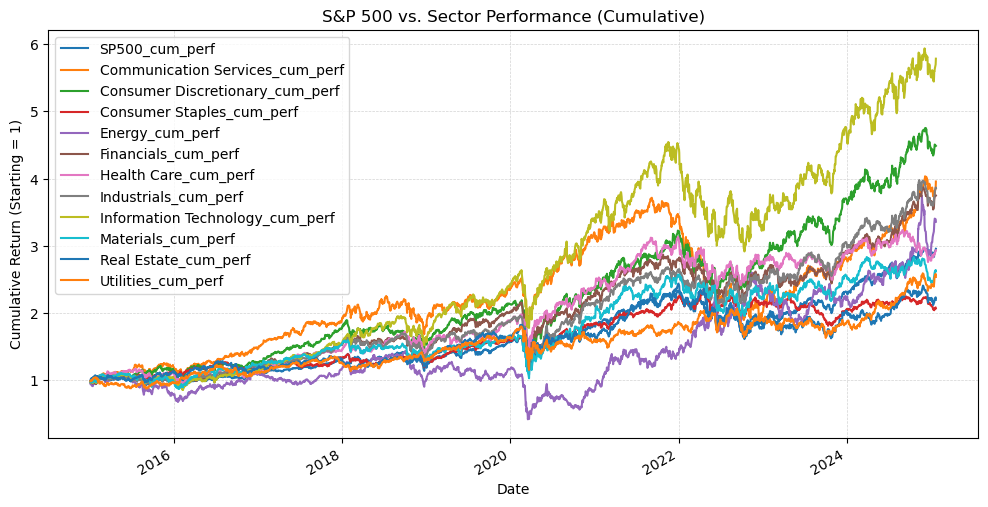

Haal nieuwsdata op via NewsScraper...
Fetching URL: https://financialpost.com/search/?search_text=stock+market&date_range=-3650d&sort=asc&from=0
Article is newer than 2015-01-26. Stopping.
Haal CPI-data op via SP500CPIAnalysis...


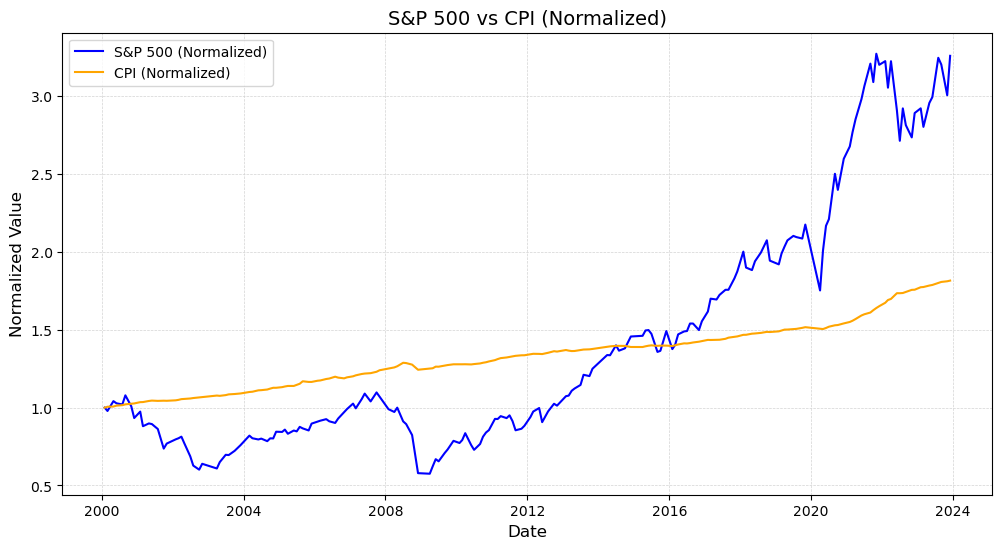

Correlation between S&P 500 returns and CPI changes: 0.2784


,Date,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,50_MA,200_MA,RSI,BB_MA,...,High,Low,Close,Adj Close,Volume,CPI,SP500_Return,SP500_Normalized,CPI_Normalized,CPI_Change
0,2000-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1412.489990,1384.790039,1409.280029,1409.280029,9.810000e+08,170.0,NaN,1.000000,1.000000,NaN
1,2000-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1383.459961,1366.420044,1379.189941,1379.189941,1.274100e+09,171.0,-0.021351,0.978649,1.005882,0.005882
2,2000-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1481.510010,1452.430054,1468.250000,1468.250000,9.663000e+08,171.2,0.064574,1.041844,1.007059,0.001170
3,2000-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1448.810059,1420.599976,1448.810059,1448.810059,9.601000e+08,172.2,-0.013240,1.028050,1.012941,0.005841
4,2000-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1443.540039,1428.959961,1438.099976,1438.099976,9.387000e+08,172.7,-0.007392,1.020450,1.015882,0.002904


In [69]:
# Initialiseer de benodigde klassen
yfinance_handler = SP500Analysis()
news_scraper = NewsScraper(base_url="https://financialpost.com/search/?search_text=stock+market&date_range=-3650d&sort=asc", until_date='2015-01-26')
cpi_analysis = SP500CPIAnalysis()  # Initialiseer een nieuwe SP500CPIAnalysis instantie

# Initialiseer de Pipeline
pipeline = Pipeline(yfinance_handler, news_scraper, cpi_analysis)

# Voer de pipeline uit
financial_data, news_df, cpi_data = pipeline.run()

# Voeg de data samen zonder de functie van de pipeline
combined_data = pd.merge(financial_data, news_df, on='Date', how='outer')
combined_data = pd.merge(combined_data, cpi_data, on='Date', how='outer')

# Toon de eerste paar rijen van de gecombineerde dataset
combined_data.head()

## Bronnenlijst

A complete explanation of Bollinger Bands. (z.d.). Bollingerbands. https://www.bollingerbands.com/bollinger-bands

Fernando, J. (2024, 19 november). Relative Strength Index (RSI) Indicator Explained With Formula. Investopedia. https://www.investopedia.com/terms/r/rsi.asp

Fernando, J. (2024a, augustus 6). Moving Average (MA): Purpose, Uses, Formula, and Examples. Investopedia. https://www.investopedia.com/terms/m/movingaverage.asp

Fernando, J. (2024b, 24 oktober). Consumer Price Index (CPI): What It Is and How It's Used. Investopedia. https://www.investopedia.com/terms/c/consumerpriceindex.asp 